In [ ]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import wandb

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PROJECT_NAME = "PRACTICA1AA2_CLASIFICADOR_PLANTAS"
ENTITY_NAME = "adriojeda04-ayuntamiento-de-las-palmas-de-gran-canaria"
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

BASE_DATA_PATH = r'imagenes_plantas'

os.environ['WANDB_API_KEY'] = '46f614d357c93d112f9541302d26febd572f0c93'
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


False

In [18]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((230, 230)),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class PlantDataset(Dataset):
    def __init__(self, base_dir, max_images_per_class=200):
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}

        if not os.path.exists(base_dir):
             raise RuntimeError(f"Error: No se encuentra el directorio {base_dir}")

        class_names = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])

        for i, class_name in enumerate(class_names):
            self.class_to_idx[class_name] = i
            class_path = os.path.join(base_dir, class_name)
            files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
            
            for filename in files[:max_images_per_class]:
                self.image_paths.append(os.path.join(class_path, filename))
                self.labels.append(i)

        self.num_classes = len(self.class_to_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        return self.image_paths[idx], self.labels[idx]

class ImageLoader(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, idx):
        original_idx = self.subset.indices[idx]
        path, label = self.subset.dataset[original_idx]
        
        img = cv2.imread(path)
        if img is None:
            img = np.zeros((224, 224, 3), dtype=np.uint8)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
        if self.transform:
            img = self.transform(img)
            
        return img, torch.tensor(label, dtype=torch.long)

    def __len__(self):
        return len(self.subset)

full_dataset = PlantDataset(BASE_DATA_PATH)
classes = list(full_dataset.class_to_idx.keys())

train_idx, test_idx = train_test_split(
    range(len(full_dataset)), test_size=0.2, stratify=full_dataset.labels, random_state=42
)

train_ds = ImageLoader(Subset(full_dataset, train_idx), transform=train_transforms)
test_ds = ImageLoader(Subset(full_dataset, test_idx), transform=val_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Datos cargados: {len(train_ds)} entrenamiento, {len(test_ds)} test.")
print(f"Clases: {classes}")

Datos cargados: 904 entrenamiento, 226 test.
Clases: ['African Violet (Saintpaulia ionantha)', 'Aloe-Vera', 'Kalanchoe', 'Lily of the valley (Convallaria majalis)', 'Money Tree (Pachira aquatica)', 'Tulip']


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

H_in, W_in = TARGET_SIZE

class ConvNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5, fc_units=256):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.final_h = H_in // 16
        self.final_w = W_in // 16
        self.flatten_dim = 256 * (224//16) * (224//16)

        self.fc1 = nn.Linear(self.flatten_dim, fc_units)
        self.fc_bn1 = nn.BatchNorm1d(fc_units)

        self.fc2 = nn.Linear(fc_units, 120)
        self.fc_bn2 = nn.BatchNorm1d(120)

        self.fc3 = nn.Linear(120, 60)
        self.fc4 = nn.Linear(60, num_classes)

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):

        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = x.flatten(1)

        x = F.relu(self.fc_bn1(self.fc1(x)))
        x = self.dropout(x)

        x = F.relu(self.fc_bn2(self.fc2(x)))
        x = self.dropout(x)

        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

model = ConvNet(num_classes=full_dataset.num_classes)
model.to(device)

print(model)

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=256, bias=True)
  (fc_bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=120, bias=True)
  (fc_bn2): BatchNo


==================== Entrenando: 1_Base ====================


Epoch 1/50 | Train Loss: 1.5690 | Val Loss: 1.3139 | Val Acc: 58.41%
Epoch 2/50 | Train Loss: 1.2643 | Val Loss: 1.1168 | Val Acc: 61.50%
Epoch 3/50 | Train Loss: 1.1106 | Val Loss: 1.2436 | Val Acc: 51.77%
Epoch 4/50 | Train Loss: 0.9805 | Val Loss: 0.9549 | Val Acc: 65.93%
Epoch 5/50 | Train Loss: 0.9534 | Val Loss: 0.9868 | Val Acc: 70.80%
Epoch 6/50 | Train Loss: 0.8559 | Val Loss: 0.7672 | Val Acc: 72.12%
Epoch 7/50 | Train Loss: 0.7914 | Val Loss: 0.7122 | Val Acc: 76.55%
Epoch 8/50 | Train Loss: 0.7631 | Val Loss: 0.7135 | Val Acc: 73.45%
Epoch 9/50 | Train Loss: 0.7219 | Val Loss: 0.6720 | Val Acc: 76.55%
Epoch 10/50 | Train Loss: 0.7685 | Val Loss: 0.7082 | Val Acc: 73.45%
Epoch 11/50 | Train Loss: 0.6532 | Val Loss: 0.6928 | Val Acc: 76.55%
Epoch 12/50 | Train Loss: 0.6512 | Val Loss: 1.2507 | Val Acc: 64.60%
Epoch 13/50 | Train Loss: 0.6648 | Val Loss: 0.7360 | Val Acc: 78.32%
Epoch 14/50 | Train Loss: 0.6128 | Val Loss: 0.6022 | Val Acc: 78.76%
Epoch 15/50 | Train Loss: 0.5

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 50/50 | Train Loss: 0.4395 | Val Loss: 0.5255 | Val Acc: 80.97%
--> Fin 1_Base. Mejor Accuracy: 82.30%


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
train_loss,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▃▃▁▄▅▇▆▇▆▇▇████▇████████████▇███████████
val_loss,█▆▇▅▅▃▃▃▃▃▃▂▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
train_loss,0.43954
val_acc,80.97345
val_loss,0.52553


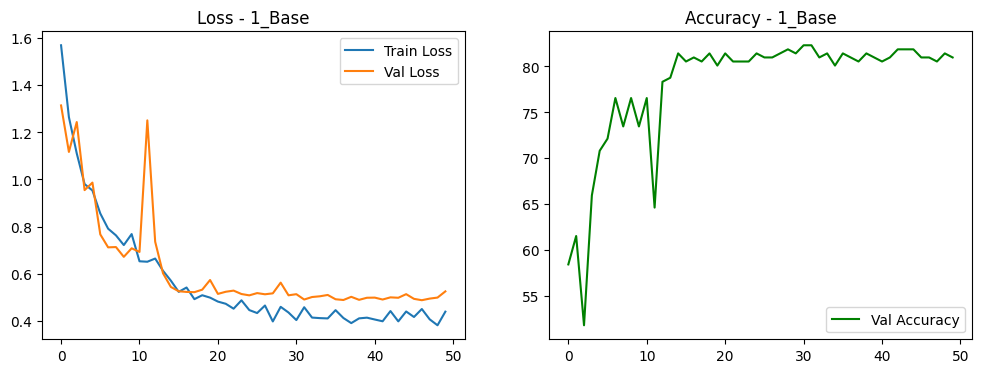


==================== Entrenando: 2_HighLR ====================


Epoch 1/50 | Train Loss: 1.5253 | Val Loss: 1.8284 | Val Acc: 51.77%
Epoch 2/50 | Train Loss: 1.2563 | Val Loss: 1.6424 | Val Acc: 46.90%
Epoch 3/50 | Train Loss: 1.1638 | Val Loss: 1.0990 | Val Acc: 62.83%
Epoch 4/50 | Train Loss: 1.1649 | Val Loss: 1.0987 | Val Acc: 62.83%
Epoch 5/50 | Train Loss: 1.1016 | Val Loss: 1.0493 | Val Acc: 63.27%
Epoch 6/50 | Train Loss: 1.0292 | Val Loss: 1.0345 | Val Acc: 62.39%
Epoch 7/50 | Train Loss: 0.9766 | Val Loss: 1.1768 | Val Acc: 65.04%
Epoch 8/50 | Train Loss: 0.9576 | Val Loss: 0.9487 | Val Acc: 65.49%
Epoch 9/50 | Train Loss: 0.9483 | Val Loss: 0.9365 | Val Acc: 67.26%
Epoch 10/50 | Train Loss: 0.9152 | Val Loss: 1.0516 | Val Acc: 69.47%
Epoch 11/50 | Train Loss: 0.9031 | Val Loss: 0.8235 | Val Acc: 73.01%
Epoch 12/50 | Train Loss: 0.8634 | Val Loss: 0.8939 | Val Acc: 69.91%
Epoch 13/50 | Train Loss: 0.8358 | Val Loss: 0.8260 | Val Acc: 73.01%
Epoch 14/50 | Train Loss: 0.7909 | Val Loss: 0.8715 | Val Acc: 69.47%
Epoch 15/50 | Train Loss: 0.8

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 50/50 | Train Loss: 0.6202 | Val Loss: 0.6856 | Val Acc: 78.76%
--> Fin 2_HighLR. Mejor Accuracy: 79.65%


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▇▇▆▆▅▅▅▅▄▃▄▃▃▂▃▂▂▂▂▂▂▁▂▂▂▁▁▁▁▂▁▂▁▁▂▁▂▂▂
val_acc,▂▁▄▄▅▅▅▅▆▇▇▆▇▇▆▇▇████▇██████████████████
val_loss,█▇▄▄▃▄▃▃▃▂▂▂▃▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
train_loss,0.62024
val_acc,78.76106
val_loss,0.68564


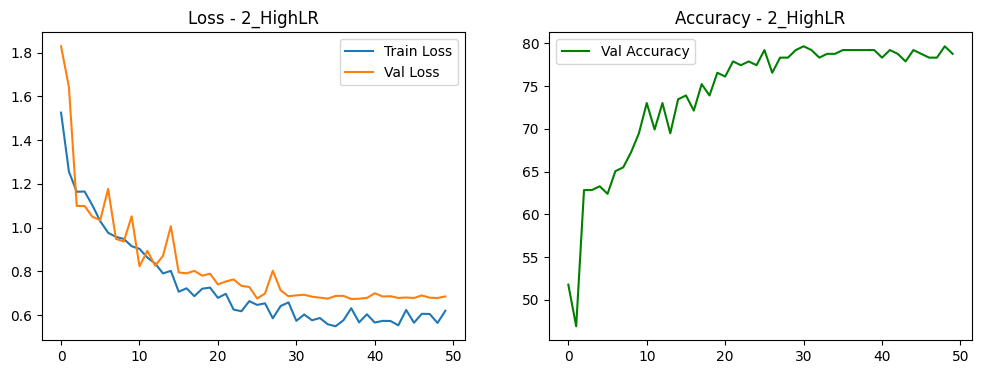


==================== Entrenando: 3_LowLR ====================


Epoch 1/50 | Train Loss: 1.7225 | Val Loss: 1.6776 | Val Acc: 47.35%
Epoch 2/50 | Train Loss: 1.5804 | Val Loss: 1.5228 | Val Acc: 64.60%
Epoch 3/50 | Train Loss: 1.4864 | Val Loss: 1.4371 | Val Acc: 68.58%
Epoch 4/50 | Train Loss: 1.4047 | Val Loss: 1.3492 | Val Acc: 66.81%
Epoch 5/50 | Train Loss: 1.3173 | Val Loss: 1.2881 | Val Acc: 68.58%
Epoch 6/50 | Train Loss: 1.2372 | Val Loss: 1.2163 | Val Acc: 69.03%
Epoch 7/50 | Train Loss: 1.1657 | Val Loss: 1.1039 | Val Acc: 70.80%
Epoch 8/50 | Train Loss: 1.0793 | Val Loss: 0.9989 | Val Acc: 73.89%
Epoch 9/50 | Train Loss: 1.0205 | Val Loss: 0.9893 | Val Acc: 74.78%
Epoch 10/50 | Train Loss: 0.9656 | Val Loss: 0.9987 | Val Acc: 73.45%
Epoch 11/50 | Train Loss: 0.9158 | Val Loss: 0.8273 | Val Acc: 76.11%
Epoch 12/50 | Train Loss: 0.8596 | Val Loss: 0.8159 | Val Acc: 76.99%
Epoch 13/50 | Train Loss: 0.8381 | Val Loss: 0.7608 | Val Acc: 77.43%
Epoch 14/50 | Train Loss: 0.7663 | Val Loss: 0.7058 | Val Acc: 77.88%
Epoch 15/50 | Train Loss: 0.7

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 50/50 | Train Loss: 0.3564 | Val Loss: 0.4672 | Val Acc: 84.51%
--> Fin 3_LowLR. Mejor Accuracy: 84.96%


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▇▇▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇▇█▇███████████████
val_loss,█▇▇▆▆▅▄▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
train_loss,0.35636
val_acc,84.51327
val_loss,0.46716


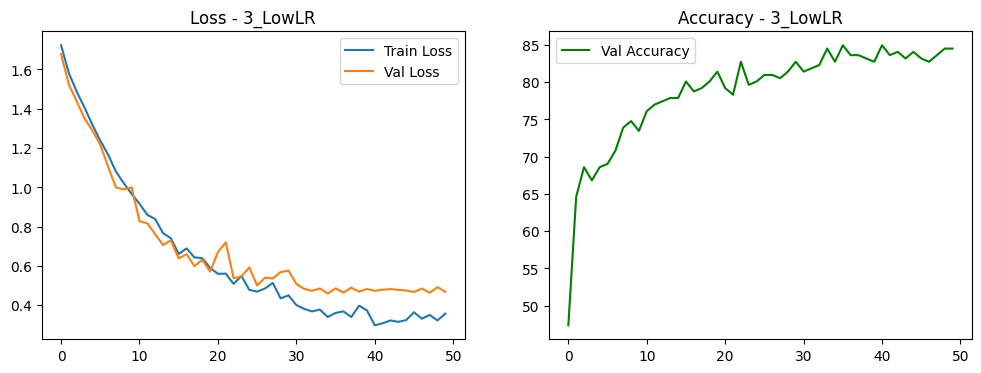


==================== Entrenando: 4_HighDrop ====================


Epoch 1/50 | Train Loss: 1.7398 | Val Loss: 1.5838 | Val Acc: 49.12%
Epoch 2/50 | Train Loss: 1.4974 | Val Loss: 1.3533 | Val Acc: 56.64%
Epoch 3/50 | Train Loss: 1.3481 | Val Loss: 1.2069 | Val Acc: 54.87%
Epoch 4/50 | Train Loss: 1.2293 | Val Loss: 1.1107 | Val Acc: 62.83%
Epoch 5/50 | Train Loss: 1.1837 | Val Loss: 1.1445 | Val Acc: 63.27%
Epoch 6/50 | Train Loss: 1.1163 | Val Loss: 1.1428 | Val Acc: 62.39%
Epoch 7/50 | Train Loss: 1.1150 | Val Loss: 1.1024 | Val Acc: 57.96%
Epoch 8/50 | Train Loss: 1.0757 | Val Loss: 1.1098 | Val Acc: 65.04%
Epoch 9/50 | Train Loss: 1.0710 | Val Loss: 1.0493 | Val Acc: 63.27%
Epoch 10/50 | Train Loss: 1.0054 | Val Loss: 0.9431 | Val Acc: 69.03%
Epoch 11/50 | Train Loss: 0.9419 | Val Loss: 1.0696 | Val Acc: 69.03%
Epoch 12/50 | Train Loss: 0.9312 | Val Loss: 0.9170 | Val Acc: 69.91%
Epoch 13/50 | Train Loss: 0.8631 | Val Loss: 0.8518 | Val Acc: 69.91%
Epoch 14/50 | Train Loss: 0.8868 | Val Loss: 0.9113 | Val Acc: 69.03%
Epoch 15/50 | Train Loss: 0.8

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 50/50 | Train Loss: 0.4500 | Val Loss: 0.5454 | Val Acc: 80.09%
--> Fin 4_HighDrop. Mejor Accuracy: 80.97%


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▇▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁
val_acc,▁▃▂▄▄▄▆▆▆▆▆▆▇▆▇▆▇▇▇█▇▇█▇████████████████
val_loss,█▆▅▅▅▅▅▄▄▅▃▃▃▄▂▃▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
train_loss,0.45002
val_acc,80.0885
val_loss,0.54542


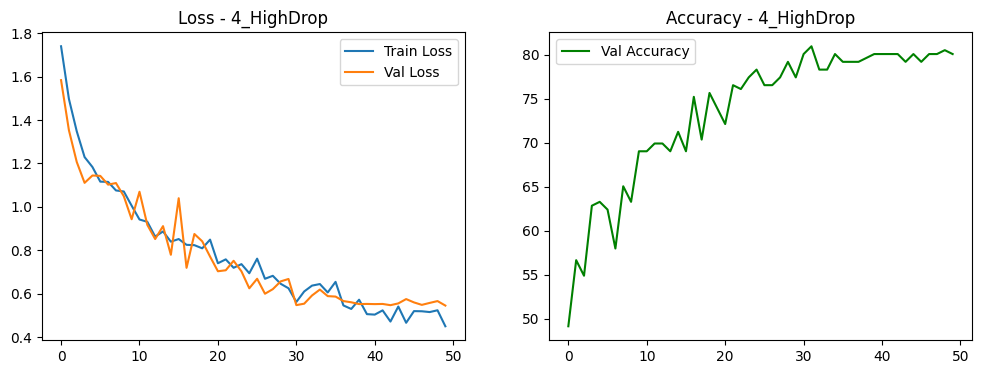


==================== Entrenando: 5_BigDense ====================


Epoch 1/50 | Train Loss: 1.5647 | Val Loss: 1.3432 | Val Acc: 59.29%
Epoch 2/50 | Train Loss: 1.2159 | Val Loss: 1.3948 | Val Acc: 53.10%
Epoch 3/50 | Train Loss: 1.0365 | Val Loss: 0.9967 | Val Acc: 65.93%
Epoch 4/50 | Train Loss: 0.9237 | Val Loss: 0.9260 | Val Acc: 65.49%
Epoch 5/50 | Train Loss: 0.8650 | Val Loss: 0.8489 | Val Acc: 71.68%
Epoch 6/50 | Train Loss: 0.8312 | Val Loss: 0.9325 | Val Acc: 70.35%
Epoch 7/50 | Train Loss: 0.7835 | Val Loss: 0.8397 | Val Acc: 73.89%
Epoch 8/50 | Train Loss: 0.7377 | Val Loss: 1.0530 | Val Acc: 64.16%
Epoch 9/50 | Train Loss: 0.7080 | Val Loss: 0.7941 | Val Acc: 75.22%
Epoch 10/50 | Train Loss: 0.7368 | Val Loss: 0.7797 | Val Acc: 76.99%
Epoch 11/50 | Train Loss: 0.6905 | Val Loss: 0.7003 | Val Acc: 79.65%
Epoch 12/50 | Train Loss: 0.6900 | Val Loss: 0.8544 | Val Acc: 75.66%
Epoch 13/50 | Train Loss: 0.5928 | Val Loss: 0.6327 | Val Acc: 75.22%
Epoch 14/50 | Train Loss: 0.5869 | Val Loss: 0.6091 | Val Acc: 79.65%
Epoch 15/50 | Train Loss: 0.6

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 50/50 | Train Loss: 0.2955 | Val Loss: 0.4469 | Val Acc: 84.96%
--> Fin 5_BigDense. Mejor Accuracy: 85.84%


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▆▅▅▄▄▄▃▄▃▃▃▃▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▂▁▄▄▅▅▃▆▆▇▇▆▇▇▇▇▇▇▇▇████████▇███████████
val_loss,██▅▅▄▄▅▃▃▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
train_loss,0.2955
val_acc,84.95575
val_loss,0.44694


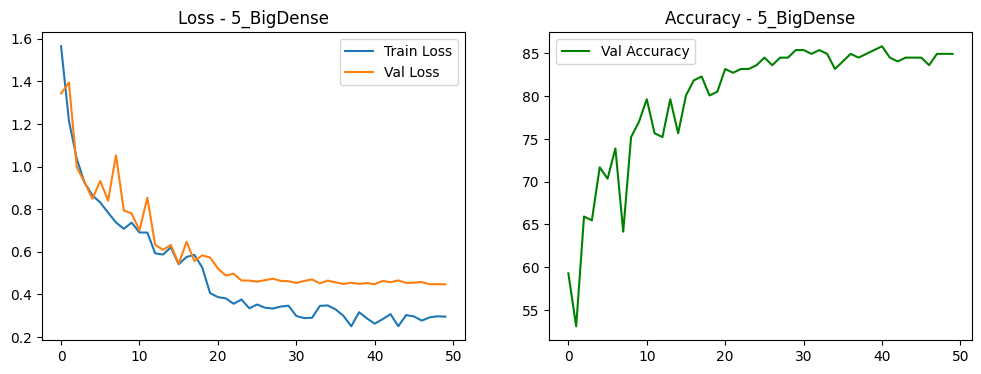


RESUMEN FINAL: {'1_Base': 82.30088495575221, '2_HighLR': 79.64601769911505, '3_LowLR': 84.95575221238938, '4_HighDrop': 80.97345132743362, '5_BigDense': 85.84070796460178}


In [ ]:
def entrenar_modelo(config_name, params):
    print(f"\n{'='*20} Entrenando: {config_name} {'='*20}")
    
    model = ConvNet(
        num_classes=len(classes), 
        dropout_rate=params['dropout'],
        fc_units=params['fc_units']
    ).to(device)
    
    run = wandb.init(
        project=PROJECT_NAME, 
        name=config_name, 
        reinit=True,
        config=params
    )
    
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
    
    epochs = params['epochs']
    best_acc = 0.0
    
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        avg_train_loss = running_loss / len(train_loader)
        
        model.eval()
        val_loss_sum = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss_sum += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        avg_val_loss = val_loss_sum / len(test_loader)
        val_acc = 100 * correct / total
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        
        scheduler.step(avg_val_loss)
        wandb.log({"train_loss": avg_train_loss, "val_loss": avg_val_loss, "val_acc": val_acc, "epoch": epoch+1})
        
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f'modelo_{config_name}.pth')
            
    print(f"--> Fin {config_name}. Mejor Accuracy: {best_acc:.2f}%")
    run.finish()
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'Loss - {config_name}')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['val_acc'], label='Val Accuracy', color='green')
    plt.title(f'Accuracy - {config_name}')
    plt.legend()
    
    plt.show() 
    
    return best_acc

experimentos = {
    "1_Base":      {'lr': 0.001,  'dropout': 0.5, 'fc_units': 256, 'epochs': 50},
    "2_HighLR":    {'lr': 0.01,   'dropout': 0.5, 'fc_units': 256, 'epochs': 50},
    "3_LowLR":     {'lr': 0.0001, 'dropout': 0.5, 'fc_units': 256, 'epochs': 50},
    "4_HighDrop":  {'lr': 0.001,  'dropout': 0.7, 'fc_units': 256, 'epochs': 50},
    "5_BigDense":  {'lr': 0.001,  'dropout': 0.5, 'fc_units': 512, 'epochs': 50}
}

resultados = {}
for nombre, params in experimentos.items():
    acc = entrenar_modelo(nombre, params)
    resultados[nombre] = acc

print("\nRESUMEN FINAL:", resultados)